# Introduction to Monte Carlo Simulation in Finance

## Valuation of American Option by Simulation

As we have seen Monte Carlo simulation is a flexible and powerful numerical method to value financial derivatives of any kind. However being a forward evolving technique, it is per se not suited to address the valuation of American or Bermudan options which are valued in general by backwards induction. Longstaff and Schwartz provide a numerically efficient method to resolve this problem by what they call Least-Squares Monte Carlo. 

The problem with Monte Carlo is that the decision to exercise an American option or not is dependent on the continuation value. Consider a simulation with $M + 1$ points in time and $I$ paths. Given a simulated index level $S_{t,i} , t\in \{0, ..., T \}, i \in \{1, ..., I \}$, what is the continuation value $C_{t,i}(S_{t,i})$, i.e. the expected payoff of not exercising the option? The approach of Longstaff-Schwartz approximates continuation values for American options in the backwards steps by an ordinary least-squares regression. 

Equipped with such approximations, the option is exercised if the approximate continuation value is lower than the value of immediate exercise. Otherwise it is not exercised.

In order to explain the metodology, let's start from a simpler problem. Consider a *bermudan option* which is similar to an american option, except that it can be early exercised once only on a specific set of dates. In the figure, we can represent the schedule of a put bermudan option with strike $K$ and maturity in $6$ years. Each year you can choose whether to exercise or not.

<img src="img/bermudan_exercise_1.png" alt="Bermudan Exercise Periods" width="50%" align="center" border="1">

Let's consider a simpler example: a put option which can be exercised early only once:

<img src="img/bermudan_exercise_2.png" alt="Bermudan Exercise Periods" width="50%" align="center" border="1">

Can we price this product by means of a Monte Carlo? Yes we can! Let's see how.

Let's implement a MC which actually simulates, besides the evolution of the market, what an investor holding this option would do (clearly an investor who lives in the risk neutral world). In the following example we will assume the following data, $S(T)=$, $K=$, $r=$, $\sigma=$, $t_1=1y$, $T=2y$.

We simulate that 1y has passed, computing the new value of the asset and the new value of the money market account

$$S(t_1 = 1y) = S(t_0)e^{(r-\frac{1}{2}\sigma^2 )(t_1-t_0) + \sigma \sqrt{t_1-t_0}N(0,1)}$$

$$B(t_1 = 1y) = B(t_0) e^{r(t_1-t_0)}$$

At this point the investor could exercise. How does he know if it is convenient? In case of exercise he knows exactly the payoff he's getting. In case he continues, he knows that it is the same of having a European Put Option.

So, in mathematical terms we have the following payoff in $t_1$

$$\max \left[
K-S(t_1), P(t_1,T;S(t_1),K)
\right] $$

Where $P(t_1,T;S(t_1),K)$ is the price of a Put which we compute analytically! In the jargon of american products, $P$ is called the continuation value, i.e. the value of holding the option instead of early exercising it.

So the premium of the option is the average of this discounted payoff calculated in each iteration of the Monte Carlo procedure.

$$
\frac{1}{N} \sum\limits_i
\max \left[
K-S_i(t_1), P(t_1,T;S_i(t_1),K)
\right] $$

Some considerations are in order. We could have priced this product because we have an analytical pricing formula for the put. What if we didn't have it? 

Brute force solution: for each realization of $S(t_1)$ we run another Monte Carlo to price the put. This method (called Nested Monte Carlo) is very time consuming. For this very simple case it's time of execution grows as $N^2$, which becomes prohibitive when you deal with more than one exercise date!

Let's search for a finer solution analyzing the relationship between the continuation value (in this very simple example) and the simulated realization of $S$ at step $t_1$. Let's first of all re-write the simple code for Black and Scholes option pricing.

In [1]:
import numpy as np
import scipy.stats as ss

#Black and Scholes
def d1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def BlackScholes(type,S0, K, r, sigma, T):
    if type=="C":
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, sigma, T)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T))


First of all generate some paths with the usual forward approach...

In [2]:
%matplotlib inline

from pylab import *
from matplotlib import pyplot as pl

np.random.seed(150000)
# Model Parameters
S0 = 36.  # initial stock level
K = 40.  # strike price
T = 1.0  # time-to-maturity
r = 0.06  # short rate
sigma = 0.2  # volatility

# Simulation Parameters
I = 10000   # number of paths
M = 50      # number of points for each path
dt = T / M
df = math.exp(-r * dt)

# Stock Price Paths
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt
    + sigma * math.sqrt(dt) * np.random.standard_normal((M + 1, I)), axis=0))
S[0] = S0


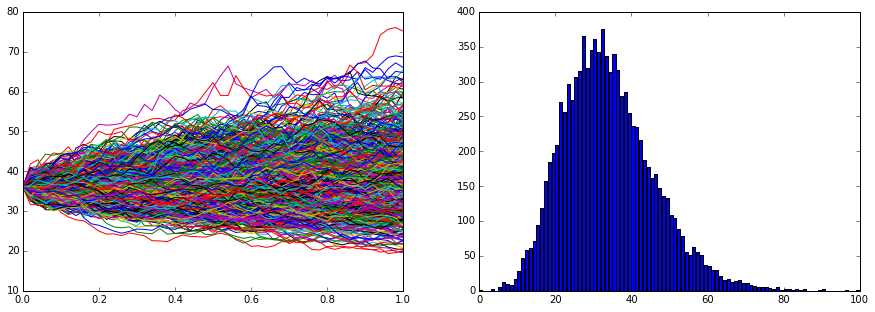

In [4]:
# plotting some path
t = np.linspace(0, T, M+1)
paths = S[:,1:1000]

# plotting expiry price distribution
expiry = S[-1,:]
hist = np.histogram(expiry, 100)
index = np.arange(100)

pl.figure(figsize=(15,5))
pl.subplot(121)
pl.plot(t, paths)

pl.subplot(122)
pl.bar(index, hist[0])

pl.show()

Now, let's plot the discounted payoff at maturity, $P_i$, versus $S_i(t_1)$

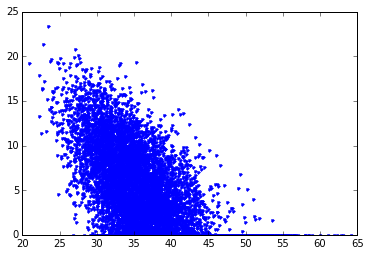

In [5]:
n = 25
maturity  = S[50,:]
reference = S[50-n,:]
payoff = np.maximum(K-maturity,0)*math.exp(-r *n*dt)
pl.plot(reference, payoff,'.')

On this plot, add the analytical price of the put as a function of $S_i(t_1)$...

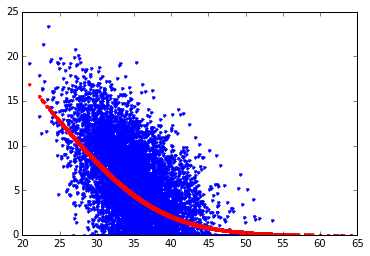

In [6]:
C = BlackScholes('P',reference, K, r, sigma, T)

pl.plot(reference, payoff,'.')
pl.plot(reference, C, '.', color='r')

As you can see, the analytical price of the put is a curve which kinds of interpolate the cloud of Monte Carlo points. This suggest us that 

+ **the price at time $t_1$ can be computed by means of an average on all discounted payoff (i.e. the barycentre of the cloud made of discounted payoff)**

So maybe...

+ **the future value of an option can be seen as the problem of finding the curve that best fits the cloud of discounted payoff (up to date of interest)!!!**

Below, for example, there is a curve found by means of a linear regression on a polynomial of 5th order...

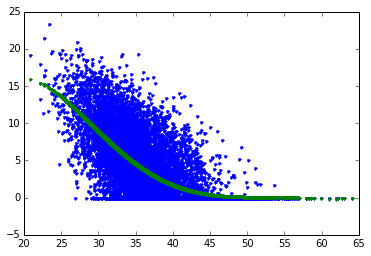

In [7]:
rg = np.polyfit(reference, payoff, 5)

y  = np.zeros(len(reference))
k  = 0
for x in reference:
    y[k] = rg[0]*x**5 + rg[1]*x**4 + rg[2]*x**3 + rg[3]*x**2 + rg[4]*x + rg[5]
    k += 1
xx=np.array(reference)

pl.plot(reference, payoff,'.')
pl.plot(xx,y,'.',color='g')    

And here we see both the curve overlapping (in green the 5th order polynomial and in red the analytical solution of black and scholes model) ...

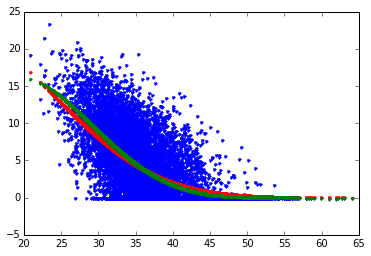

In [8]:
pl.plot(reference, payoff,'.')
pl.plot(reference, C, '.', color='r')
pl.plot(xx,y,'.',color='g')    

We now have an empirical pricing formula for the put to be used in my MCS

$$P(t_1, T, S(t_1), K) = c_0 + c_1S(t_1) + c_2S(t_1)^2 + c_3S(t_1)^3 + c_4S(t_1)^4 + c_5S(t_1)^5$$

The formula is obviously fast, the cost of the algorithm being the best fit. Please note that we could have used any form for the curve (not only a plynomial). This method has the advantage that it can be solved as a linear regression, which is fast.

## The Longstaff-Schwartz Algorithm


The major insight of Longstaff-Schwartz is to estimate the continuation value $C_{t,i}$ by ordinary least-squares regression, therefore the name *Least Square Monte Carlo* for their algorithm, they propose to regress the $I$ continuation values $Y_{t,i}$ against the $I$ simulated index levels $S_{t,i}$. Given $D$  basis functions $b$ with $b_1, \dots, b_D : \mathbb{R}^D \rightarrow \mathbb{R}$ for the regression, the continuation value $C_{t,i}$ is according to their approach approximated by: 

$$
\hat C_{t,i} = \sum\limits_{d=1}^D \alpha^\star_{d,t} b_d(S_{t,i})  \quad (1)
$$

The optimal regression parameters $\alpha^\star_{d,t}$ are the result of the minimization 

$$
\min\limits_{\alpha_{1,t}, \dots, \alpha_{D,t}}   \frac{1}{I} \sum\limits_{i=1}^I 
\left( Y_{t,i} - \sum\limits_{d=1}^D \alpha_{d,t} b_d(S_{t,i}) \right)^2
$$

In some circumstances, the quality of the regression can be improved upon when restricting the paths involved in the regression to those where the option is in-the-money.

Let's consider now a generic american product. Here is the Longstaff-Schwartz algorithm:

+ simulate $I$ index level paths with $M + 1$ points in time leading to index level values 
$S_{t,i} , t\in \{0, ..., T \}, i \in \{1, ..., I \}$;
+ for $t=T$ the option value is $V_{T,i} = h_T(S_{T,i})$ by arbitrage
+ start iterating backwards $t = T - \Delta t , \dots, \Delta t$:
    + regress the $T_{t,i}$ against the $S_{t,i}, i \in \{1, \dots, I\}$, given $D$ basis function $b$
    + approximate $C_{t,i}$ by $\hat C_{t,i}$ according to (1) given the optimal parameters $\alpha^\star_{d,t}$ from       (2)
    + set 
    $$V_{t,i}= 
    \begin{cases}
      h_t(S_{t,i})       & \quad \text{if } h_t(S_{t,i}) >   \hat C_{t,i} \quad \text{exercise takes place}\\
      Y_{t,i}            & \quad \text{if } h_t(S_{t,i}) \le \hat C_{t,i} \quad \text{no exercise takes place}\\
    \end{cases}
    $$
  repeat iteration steps until $t=\Delta t$;
+ for $t=0$ calculate the LSM estimator
$$
\hat V_0^{LSM} = e^{-r \Delta t} \frac{1}{I}  \sum\limits_{i=1}^I V_{\Delta t,i} 
$$

So let'se the complete code...

In [28]:
#
# Valuation of American Options
# with Least-Squares Monte Carlo
# Primal Algorithm
# American Put Option
# 07_amo/LSM_primal_valuation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import math
import numpy as np
np.random.seed(150000)

# Model Parameters
S0 = 36.  # initial stock level
K = 40.  # strike price
T = 1.0  # time-to-maturity
r = 0.06  # short rate
sigma = 0.2  # volatility

# Simulation Parameters
I = 25000
M = 50
dt = T / M
df = math.exp(-r * dt)

# Stock Price Paths
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt
    + sigma * math.sqrt(dt) * np.random.standard_normal((M + 1, I)), axis=0))
S[0] = S0

# Inner Values
h = np.maximum(K - S, 0)

# Present Value Vector (Initialization)
V = h[-1]

# American Option Valuation by Backwards Induction
for t in xrange(M - 1, 0, -1):
    rg = np.polyfit(S[t], V * df, 5)
    C = np.polyval(rg, S[t])  # continuation values
    V = np.where(h[t] > C, h[t], V * df)
      # exercise decision
V0 = df * np.sum(V) / I  # LSM estimator

print "American put option value %5.3f" % V0

American put option value 4.475


## Credits

Yves Hilpisch **Derivatives Analytics with Python**

Tommaso Gabbriellini **American Options with Monte Carlo** [Presentation on Slideshare](http://www.slideshare.net/TommasoGabbriellini/uni-siena-20-maggio-2011-longstaffschwarz?qid=5b2082a4-a42b-45fb-a59b-a6acf8462ccb&v=&b=&from_search=1)
